# Topic-dependent threshold diagnostic (oracle)

This notebook consumes `pair_scores_*.jsonl` dumped by `dump_pair_scores.py` and computes:

- Per-topic **oracle** probability threshold $\tau^*$ that maximizes pairwise F1 on **all within-topic pairs**.
- Global best single $\tau$ (micro-F1 across all pairs).
- Upper bound from per-topic $\tau^*$ (micro-F1 if you were allowed to pick $\tau$ per topic).
- Correlations of $\tau^*$ with topic size and within-topic positive rate.

This is an **analysis tool** to quantify how much a single global threshold may be costing you.


In [1]:
import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

# ---------- user parameters ----------
scores_path = 'output/output_neg30/pair_scores_dev.jsonl'  # TODO
split = 'validation'
temperature_json = 'output/output_neg30/temperature_dev.json'  # TODO (or None)

tau_min, tau_max, tau_step = 0.05, 0.99, 0.01
out_dir = 'diagnostics_topic_tau'
save_csv = True
save_plots = True

os.makedirs(out_dir, exist_ok=True)

def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))

def rankdata(a: np.ndarray) -> np.ndarray:
    # simple average-rank for ties
    order = np.argsort(a)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(len(a), dtype=float)
    # handle ties
    s = a[order]
    i = 0
    while i < len(s):
        j = i + 1
        while j < len(s) and s[j] == s[i]:
            j += 1
        if j - i > 1:
            avg = (i + (j - 1)) / 2.0
            ranks[order[i:j]] = avg
        i = j
    return ranks

def pearsonr(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.size < 2:
        return float('nan')
    x = x - x.mean()
    y = y - y.mean()
    denom = (np.sqrt((x * x).sum()) * np.sqrt((y * y).sum()))
    return float((x * y).sum() / denom) if denom > 0 else float('nan')

def spearmanr(x: np.ndarray, y: np.ndarray) -> float:
    rx = rankdata(np.asarray(x))
    ry = rankdata(np.asarray(y))
    return pearsonr(rx, ry)

# temperature
T = 1.0
if temperature_json and os.path.exists(temperature_json):
    with open(temperature_json, 'r', encoding='utf-8') as f:
        T = float(json.load(f)['temperature'])
print('Temperature T =', T)

taus = np.arange(tau_min, tau_max + 1e-12, tau_step, dtype=float)
print('tau grid:', taus[0], '...', taus[-1], 'n=', len(taus))


Temperature T = 3.27769136428833
tau grid: 0.05 ... 0.9900000000000002 n= 95


In [2]:
# ---------- load pair dumps ----------
def load_pair_scores(path: str) -> dict:
    by_tid = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            by_tid[int(obj['topic_id'])] = obj
    return by_tid

scores_by_tid = load_pair_scores(scores_path)
print('loaded topics:', len(scores_by_tid))

# ---------- load SciCo split ----------
ds = load_dataset('allenai/scico')[split]
by_id = {int(r['id']): r for r in ds}
common_tids = sorted(set(scores_by_tid.keys()) & set(by_id.keys()))
print('topics with both scores and gold:', len(common_tids))


loaded topics: 100
topics with both scores and gold: 100


In [3]:
# ---------- per-topic arrays + fast metric computation over tau grid ----------
def topic_edge_arrays(tid: int):
    obj = scores_by_tid[tid]
    row = by_id[tid]
    n = int(obj['n'])
    mentions = row['mentions']
    if len(mentions) != n:
        return None
    gold_cids = [int(m[3]) for m in mentions]

    probs = np.empty(len(obj['edges']), dtype=np.float32)
    labels = np.empty(len(obj['edges']), dtype=np.int8)
    for k, e in enumerate(obj['edges']):
        i, j = int(e['i']), int(e['j'])
        z = float(e['logit'])
        p = float(sigmoid(z / T))
        probs[k] = p
        labels[k] = 1 if gold_cids[i] == gold_cids[j] else 0
    return n, probs, labels

def metrics_over_tau_grid(probs: np.ndarray, labels: np.ndarray, taus: np.ndarray):
    # sort ascending for searchsorted
    order = np.argsort(probs)
    ps = probs[order]
    ys = labels[order].astype(np.int64)
    cum_tp = np.cumsum(ys)
    total_tp = int(cum_tp[-1]) if len(cum_tp) else 0
    N = len(ps)

    prec = np.zeros(len(taus), dtype=float)
    rec = np.zeros(len(taus), dtype=float)
    f1 = np.zeros(len(taus), dtype=float)
    tp_arr = np.zeros(len(taus), dtype=np.int64)
    fp_arr = np.zeros(len(taus), dtype=np.int64)
    fn_arr = np.zeros(len(taus), dtype=np.int64)

    for t_i, tau in enumerate(taus):
        idx = int(np.searchsorted(ps, tau, side='left'))  # first >= tau
        pred_pos = N - idx
        tp = total_tp - (int(cum_tp[idx - 1]) if idx > 0 else 0)
        fp = pred_pos - tp
        fn = total_tp - tp
        tp_arr[t_i] = tp
        fp_arr[t_i] = fp
        fn_arr[t_i] = fn
        p = tp / pred_pos if pred_pos > 0 else 0.0
        r = tp / total_tp if total_tp > 0 else 0.0
        prec[t_i] = p
        rec[t_i] = r
        f = (2 * p * r / (p + r)) if (p + r) > 0 else 0.0
        f1[t_i] = f
    return prec, rec, f1, tp_arr, fp_arr, fn_arr

# Build per-topic stats
rows = []
topic_cache = {}
for tid in common_tids:
    arr = topic_edge_arrays(tid)
    if arr is None:
        continue
    n, probs, labels = arr
    pos_rate = float(labels.mean()) if len(labels) else 0.0
    prec, rec, f1, tp_arr, fp_arr, fn_arr = metrics_over_tau_grid(probs, labels, taus)

    # oracle tau*: maximize f1; tie-break: higher precision, then higher tau
    best_idx = int(np.argmax(f1))
    best_f1 = float(f1[best_idx])
    # tie-break
    cand = np.where(np.isclose(f1, best_f1))[0]
    if len(cand) > 1:
        # among ties, pick max precision
        best_p = np.max(prec[cand])
        cand2 = cand[np.where(np.isclose(prec[cand], best_p))[0]]
        # among those, pick highest tau
        best_idx = int(cand2[np.argmax(taus[cand2])])

    tau_star = float(taus[best_idx])
    rows.append({
        'topic_id': int(tid),
        'n_mentions': int(n),
        'n_pairs': int(len(labels)),
        'pos_rate': float(pos_rate),
        'tau_star': float(tau_star),
        'prec_star': float(prec[best_idx]),
        'rec_star': float(rec[best_idx]),
        'f1_star': float(f1[best_idx]),
    })
    topic_cache[tid] = {
        'n': n,
        'pos_rate': pos_rate,
        'prec': prec,
        'rec': rec,
        'f1': f1,
        'tp': tp_arr,
        'fp': fp_arr,
        'fn': fn_arr,
    }

df = pd.DataFrame(rows)
print('topics analyzed:', len(df))
df.head()


topics analyzed: 100


,topic_id,n_mentions,n_pairs,pos_rate,tau_star,prec_star,rec_star,f1_star
0,742,41,820,0.100000,0.88,0.780488,0.780488,0.780488
1,743,49,1176,0.089286,0.91,0.583333,0.800000,0.674699
2,744,45,990,0.279798,0.20,0.974820,0.978339,0.976577
3,745,62,1891,0.298784,0.19,0.895425,0.727434,0.802734
4,746,76,2850,0.143158,0.19,0.730193,0.835784,0.779429


<Axes: >

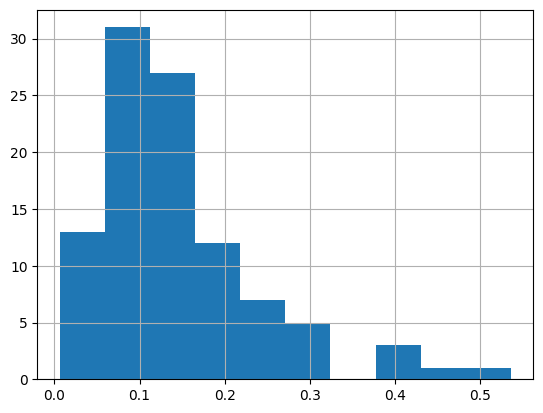

In [9]:
df.pos_rate.hist()

In [4]:
# ---------- global micro-F1 over tau grid ----------
tp_global = np.zeros(len(taus), dtype=np.int64)
fp_global = np.zeros(len(taus), dtype=np.int64)
fn_global = np.zeros(len(taus), dtype=np.int64)

for tid, obj in topic_cache.items():
    tp_global += obj['tp']
    fp_global += obj['fp']
    fn_global += obj['fn']

prec_global = np.divide(tp_global, tp_global + fp_global, out=np.zeros_like(tp_global, dtype=float), where=(tp_global+fp_global)>0)
rec_global = np.divide(tp_global, tp_global + fn_global, out=np.zeros_like(tp_global, dtype=float), where=(tp_global+fn_global)>0)
f1_global = np.divide(2*prec_global*rec_global, prec_global+rec_global, out=np.zeros_like(prec_global, dtype=float), where=(prec_global+rec_global)>0)

best_g = int(np.argmax(f1_global))
tau_global = float(taus[best_g])
print('Global best tau (micro-F1):', tau_global, 'F1=', float(f1_global[best_g]), 'P=', float(prec_global[best_g]), 'R=', float(rec_global[best_g]))


Global best tau (micro-F1): 0.5700000000000002 F1= 0.725876953338433 P= 0.6960599392224668 R= 0.7583628268067131


In [6]:
# ---------- oracle per-topic tau* upper bound (micro-F1 if you can pick tau per topic) ----------
tp_oracle = 0
fp_oracle = 0
fn_oracle = 0

for r in rows:
    tid = r['topic_id']
    tau_star = r['tau_star']
    # find closest index in grid
    idx = int(np.round((tau_star - tau_min) / tau_step))
    idx = max(0, min(idx, len(taus)-1))
    obj = topic_cache[tid]
    tp_oracle += int(obj['tp'][idx])
    fp_oracle += int(obj['fp'][idx])
    fn_oracle += int(obj['fn'][idx])

p_or = tp_oracle / (tp_oracle + fp_oracle) if (tp_oracle + fp_oracle) > 0 else 0.0
r_or = tp_oracle / (tp_oracle + fn_oracle) if (tp_oracle + fn_oracle) > 0 else 0.0
f_or = (2*p_or*r_or/(p_or+r_or)) if (p_or+r_or)>0 else 0.0

print('Oracle per-topic tau* micro-F1 upper bound:', f_or, 'P=', p_or, 'R=', r_or)
print('Absolute gain vs global best:', f_or - float(f1_global[best_g]))


Oracle per-topic tau* micro-F1 upper bound: 0.7663342597133671 P= 0.7330587989991659 R= 0.8027742893024318
Absolute gain vs global best: 0.040457306374934054


In [7]:
# ---------- correlations ----------
tau_star = df['tau_star'].to_numpy(dtype=float)
n_mentions = df['n_mentions'].to_numpy(dtype=float)
pos_rate = df['pos_rate'].to_numpy(dtype=float)

print('tau* summary: mean', float(tau_star.mean()), 'std', float(tau_star.std()), 'p10', float(np.quantile(tau_star, 0.1)), 'p50', float(np.quantile(tau_star, 0.5)), 'p90', float(np.quantile(tau_star, 0.9)))

print('\nCorrelation tau* vs n_mentions')
print('  pearson :', pearsonr(tau_star, n_mentions))
print('  spearman:', spearmanr(tau_star, n_mentions))

print('\nCorrelation tau* vs pos_rate')
print('  pearson :', pearsonr(tau_star, pos_rate))
print('  spearman:', spearmanr(tau_star, pos_rate))


tau* summary: mean 0.5421 std 0.3174469877003089 p10 0.16900000000000004 p50 0.6100000000000001 p90 0.9100000000000003

Correlation tau* vs n_mentions
  pearson : -0.0036544195113082886
  spearman: -0.07014554989534551

Correlation tau* vs pos_rate
  pearson : -0.34354125421631104
  spearman: -0.3996537166696595


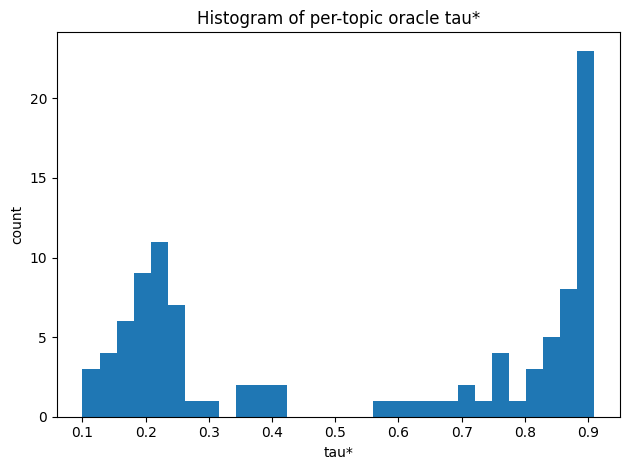

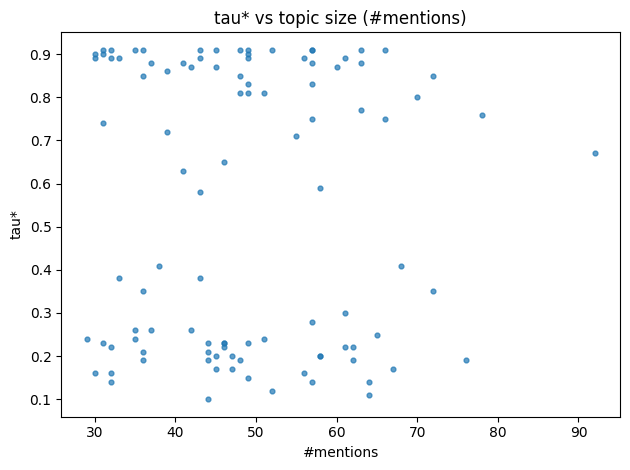

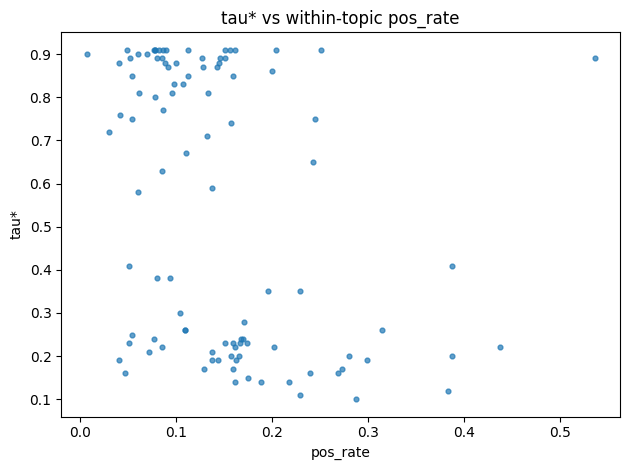

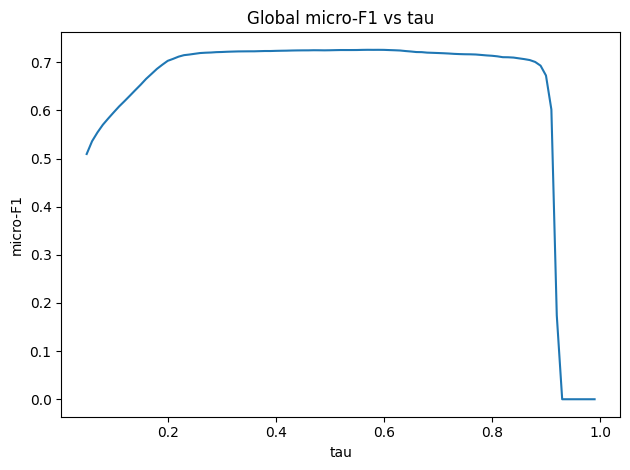

In [8]:
# ---------- plots ----------
plt.figure()
plt.hist(tau_star, bins=30)
plt.title('Histogram of per-topic oracle tau*')
plt.xlabel('tau*')
plt.ylabel('count')
plt.tight_layout()
if save_plots:
    plt.savefig(os.path.join(out_dir, 'hist_tau_oracle.png'), dpi=160)
plt.show()

plt.figure()
plt.scatter(n_mentions, tau_star, s=12, alpha=0.7)
plt.title('tau* vs topic size (#mentions)')
plt.xlabel('#mentions')
plt.ylabel('tau*')
plt.tight_layout()
if save_plots:
    plt.savefig(os.path.join(out_dir, 'scatter_tau_vs_n.png'), dpi=160)
plt.show()

plt.figure()
plt.scatter(pos_rate, tau_star, s=12, alpha=0.7)
plt.title('tau* vs within-topic pos_rate')
plt.xlabel('pos_rate')
plt.ylabel('tau*')
plt.tight_layout()
if save_plots:
    plt.savefig(os.path.join(out_dir, 'scatter_tau_vs_pos_rate.png'), dpi=160)
plt.show()

plt.figure()
plt.plot(taus, f1_global)
plt.title('Global micro-F1 vs tau')
plt.xlabel('tau')
plt.ylabel('micro-F1')
plt.tight_layout()
if save_plots:
    plt.savefig(os.path.join(out_dir, 'global_micro_f1_vs_tau.png'), dpi=160)
plt.show()


In [ ]:
# ---------- save CSVs ----------
if save_csv:
    df.to_csv(os.path.join(out_dir, 'per_topic_tau_oracle.csv'), index=False)
    grid_df = pd.DataFrame({
        'tau': taus,
        'tp': tp_global,
        'fp': fp_global,
        'fn': fn_global,
        'precision': prec_global,
        'recall': rec_global,
        'f1': f1_global,
    })
    grid_df.to_csv(os.path.join(out_dir, 'global_tau_grid_micro.csv'), index=False)
    print('Saved CSVs to', out_dir)

# save a short JSON summary
summary = {
    'temperature': T,
    'n_topics': int(len(df)),
    'global_best': {
        'tau': tau_global,
        'precision': float(prec_global[best_g]),
        'recall': float(rec_global[best_g]),
        'f1': float(f1_global[best_g]),
    },
    'oracle_upper_bound': {
        'micro_precision': float(p_or),
        'micro_recall': float(r_or),
        'micro_f1': float(f_or),
        'absolute_gain_vs_global': float(f_or - float(f1_global[best_g])),
    },
    'tau_star_summary': {
        'mean': float(tau_star.mean()),
        'std': float(tau_star.std()),
        'p10': float(np.quantile(tau_star, 0.1)),
        'p50': float(np.quantile(tau_star, 0.5)),
        'p90': float(np.quantile(tau_star, 0.9)),
    },
    'corr': {
        'tau_vs_n_mentions': {
            'pearson': pearsonr(tau_star, n_mentions),
            'spearman': spearmanr(tau_star, n_mentions),
        },
        'tau_vs_pos_rate': {
            'pearson': pearsonr(tau_star, pos_rate),
            'spearman': spearmanr(tau_star, pos_rate),
        },
    },
}

with open(os.path.join(out_dir, 'topic_tau_summary.json'), 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)
print('Saved summary JSON to', os.path.join(out_dir, 'topic_tau_summary.json'))
